In [20]:
from redbaron import redbaron
redbaron.ipython_behavior = False

import numpy as np
np.random.seed(0)  # reproduce tests
import scipy.signal
import pandas as pd
from pyha.common.util import plot_freqz
from pyha import Sfix, simulate, hardware_sims_equal, sims_close
import os

# this ignores some 'log' warnings that would fail the unit tests as they include system path
import warnings
warnings.filterwarnings('ignore')


import matplotlib
# set 'interactive' to False and run 'Restart & Run all' before you commit this notebook, else you will get failed tests in CI.
# also consider running in virtualenv, tests may fail if, for example, matplotlib versions differ
interactive = True
if interactive:
    matplotlib.use('nbagg')
    from pylab import rcParams
    rcParams['figure.figsize'] = 9, 4
    %load_ext autoreload
    %autoreload 2
    
import matplotlib.pyplot as plt
def show_plot():
    plt.tight_layout()
    plt.grid()
    if plt.gca().get_legend_handles_labels() != ([], []):
        plt.legend()
    plt.show()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Design filter

In [ ]:
taps = scipy.signal.remez(64, [0, 0.2, 0.275, 0.5], [1, 0])
print(np.sum(np.abs(taps)))
plot_freqz(taps)

[autoreload of _frozen_importlib failed: Traceback (most recent call last):
  File "/home/gaspar/git/pyha_demo_project/venv/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 246, in check
    superreload(m, reload, self.old_objects)
  File "/home/gaspar/git/pyha_demo_project/venv/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 369, in superreload
    module = reload(module)
  File "/home/gaspar/git/pyha_demo_project/venv/lib/python3.6/imp.py", line 314, in reload
    """
  File "/home/gaspar/git/pyha_demo_project/venv/lib/python3.6/importlib/__init__.py", line 165, in reload
    spec = module.__spec__ = _bootstrap._find_spec(name, pkgpath, target)
AttributeError: module 'importlib._bootstrap' has no attribute '_find_spec'
]
[autoreload of _frozen_importlib_external failed: Traceback (most recent call last):
  File "/home/gaspar/git/pyha_demo_project/venv/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 246, in check
    superrelo

[autoreload of _virtualenv_distutils failed: Traceback (most recent call last):
  File "/home/gaspar/git/pyha_demo_project/venv/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 246, in check
    superreload(m, reload, self.old_objects)
  File "/home/gaspar/git/pyha_demo_project/venv/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 369, in superreload
    module = reload(module)
  File "/home/gaspar/git/pyha_demo_project/venv/lib/python3.6/imp.py", line 314, in reload
    """
  File "/home/gaspar/git/pyha_demo_project/venv/lib/python3.6/importlib/__init__.py", line 166, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 589, in _exec
AttributeError: 'NoneType' object has no attribute 'name'
]
[autoreload of http.client failed: Traceback (most recent call last):
  File "/home/gaspar/git/pyha_demo_project/venv/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 246, in check
    superreload(m, rel

# Pyha model

In [3]:
from pyha import Hardware
class BasebandFilter(Hardware):
    def __init__(self, taps):
        self.TAPS = taps
        
    def main(self):
        pass

    def model_main(self, x):
        return scipy.signal.lfilter(self.TAPS, [1.0], x)
    
simulations = ['MODEL']

# Experiment 1: frequency response

In [32]:
# get impulse response of the filter
inp = [0.0 + 0.0j] * 512
inp[0] = 1.0 + 1.0j

In [33]:
dut = BasebandFilter(taps)
sims = simulate(dut,
                inp,
                simulations=['MODEL']
               )

INFO:simulation:Running MODEL simulation!
INFO:simulation:Simulations completed!


<IPython.core.display.Javascript object>


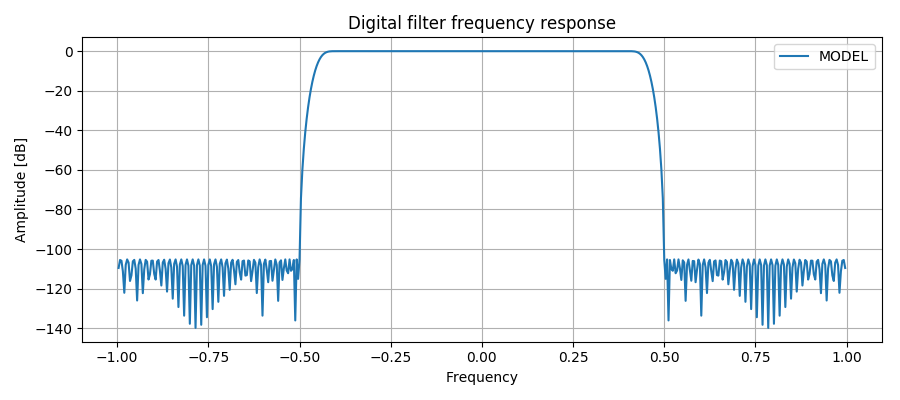

In [34]:
gain_fix = 512-128-22 # this is not 100% precise
plt.title('Digital filter frequency response')
plt.magnitude_spectrum(np.array(sims['MODEL']) * gain_fix, window=matplotlib.mlab.window_none, scale='dB', label='MODEL')
plt.ylabel('Amplitude [dB]')
plt.xlabel('Frequency')
show_plot()

# Experiment 2: two peaks

<IPython.core.display.Javascript object>


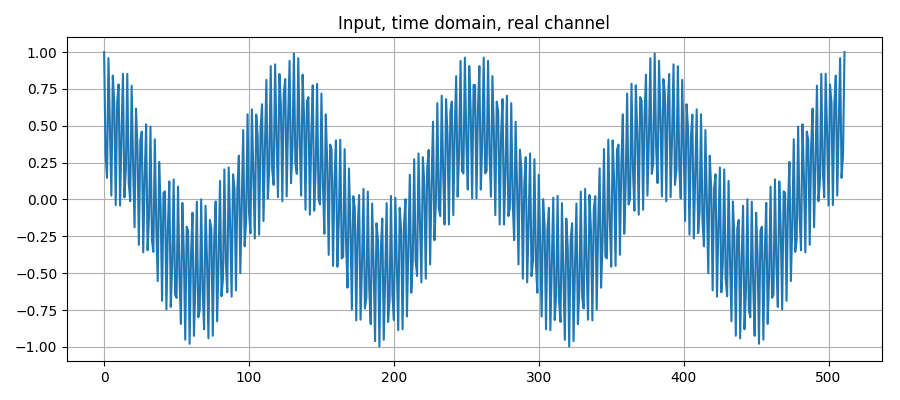

<IPython.core.display.Javascript object>


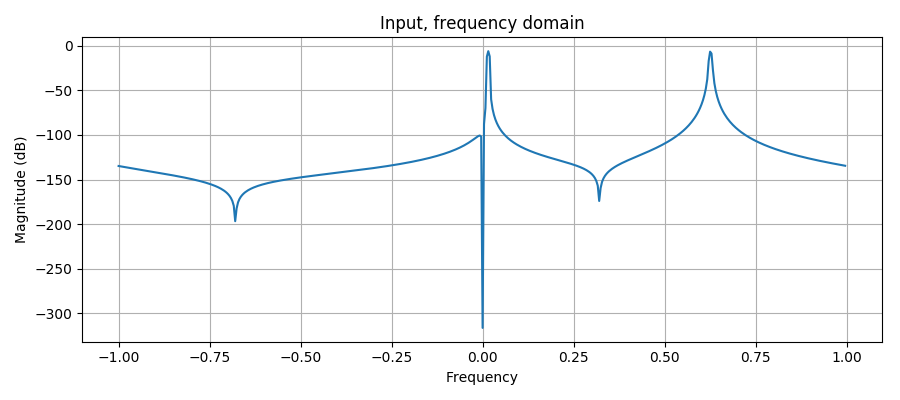

In [16]:
fs = 256
t = np.linspace(0, 2, 2*fs)
s0 = np.exp(2 * np.pi * 2 * t * 1j) * 0.5
s1 = np.exp(2 * np.pi * 80 * t * 1j) * 0.5
inp = s0 + s1

plt.title('Input, time domain, real channel')
plt.plot(inp.real)
show_plot()

plt.title('Input, frequency domain')
plt.magnitude_spectrum(inp, scale='dB')
show_plot()

In [14]:
dut = BasebandFilter(taps)
sims = simulate(dut, inp, simulations=['MODEL']) # run all simulations

INFO:simulation:Running MODEL simulation!
INFO:simulation:Simulations completed!


<IPython.core.display.Javascript object>


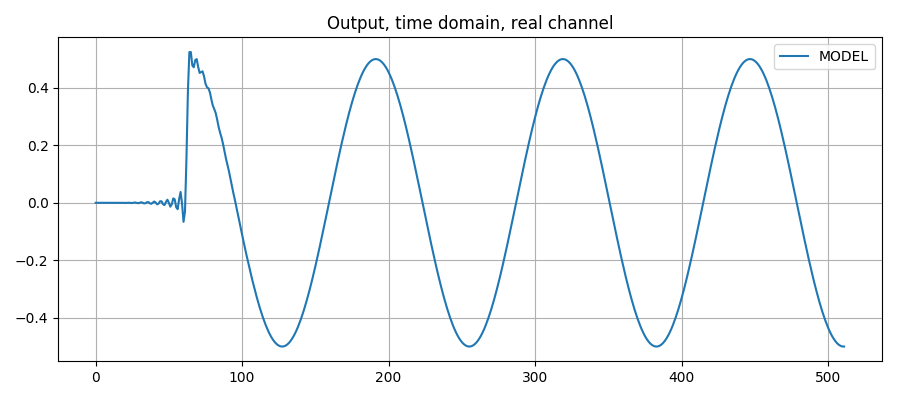

<IPython.core.display.Javascript object>


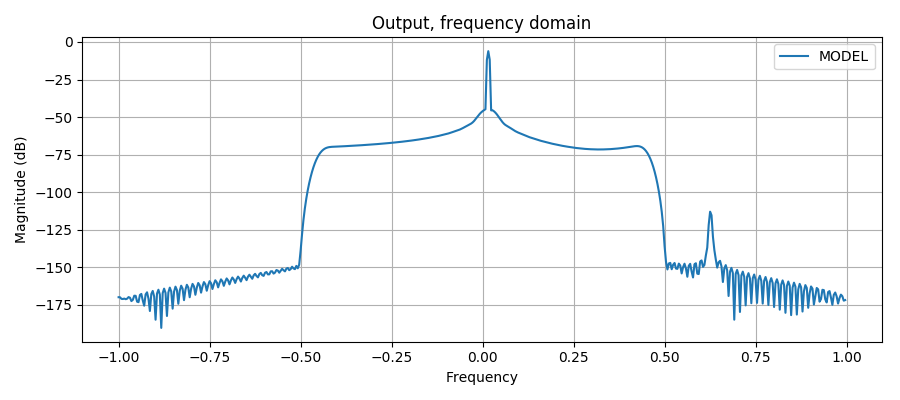

In [17]:
plt.title('Output, time domain, real channel')
plt.plot(np.array(sims['MODEL']).real, label='MODEL')
show_plot()

plt.title('Output, frequency domain')
plt.magnitude_spectrum(sims['MODEL'], scale='dB', label='MODEL')
show_plot()

# Noise response

In [18]:
inp = np.random.uniform(-1, 1, 512) + np.random.uniform(-1, 1, 512)*1j
inp *= 0.75

dut = BasebandFilter(taps)
sims = simulate(dut, inp, simulations=['MODEL'])

INFO:simulation:Running MODEL simulation!
INFO:simulation:Simulations completed!


<IPython.core.display.Javascript object>


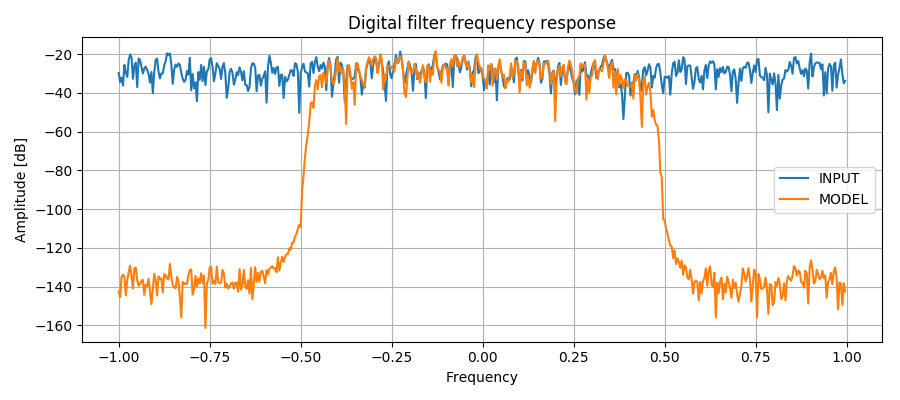

In [22]:
plt.title('Digital filter frequency response')
plt.magnitude_spectrum(inp, scale='dB', label='INPUT')
plt.magnitude_spectrum(sims['MODEL'], scale='dB', label='MODEL')
plt.ylabel('Amplitude [dB]')
plt.xlabel('Frequency')
show_plot()